# Build station features and exploratory analysis

This notebook processes minute-level GTFS-realtime snapshots, 
builds station-level features and explores the resulting dataset.

In [1]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz

from metro_disruptions_intelligence.features import SnapshotFeatureBuilder
from metro_disruptions_intelligence.processed_reader import load_rt_dataset

In [2]:
project_root = Path.cwd()
if not (project_root / "notebooks").exists():
    project_root = project_root.parent

processed_rt = project_root / "data" / "processed_final" / "rt"
features_root = project_root / "data" / "stations_features_time_series"
features_root.mkdir(parents=True, exist_ok=True)

In [3]:
processed_rt, features_root

(WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/processed_final/rt'),
 WindowsPath('c:/Users/Luis.ParraMorales/GitProjects/metro_disruptions_intelligence/data/stations_features_time_series'))

## Available routes

In [6]:
trip_ds = load_rt_dataset(processed_rt, feeds=["trip_updates"])
unique_routes = trip_ds["route_id"].unique()
print("Routes found:", unique_routes)

Routes found: ['SMNW_M1']


## Helper functions

In [4]:
def discover_all_snapshot_minutes(root: Path) -> list[int]:
    """Return all snapshot minutes from trip update files."""
    files = sorted((root / "trip_updates").rglob("trip_updates_*.parquet"))
    minutes = []
    for f in files:
        ts_part = f.stem.split("trip_updates_")[-1]
        try:
            dt = datetime.strptime(ts_part, "%Y-%d-%m-%H-%M").replace(tzinfo=pytz.UTC)
        except ValueError:
            continue
        minutes.append(int(dt.timestamp()))
    return sorted(minutes)


def compose_path(ts: int, root: Path, feed: str) -> Path:
    """Construct path for a feed timestamp."""
    dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
    fname = f"{feed}_{dt:%Y-%d-%m-%H-%M}.parquet"
    return (
        root / feed / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}" / fname
    )


def build_route_map(root: Path) -> dict:
    """Return route-to-stop mapping from first snapshot."""
    first = sorted((root / "trip_updates").rglob("*.parquet"))[0]
    df = pd.read_parquet(first)
    tu = df[["route_id", "direction_id", "stop_id", "stop_sequence"]].drop_duplicates()
    tu = tu.sort_values(["route_id", "direction_id", "stop_sequence"])
    return tu.groupby(["route_id", "direction_id"])["stop_id"].apply(list).to_dict()

## Generate features

In [5]:
minutes = discover_all_snapshot_minutes(processed_rt)
route_map = build_route_map(processed_rt)
builder = SnapshotFeatureBuilder(route_map)

for ts in minutes:
    tu_file = compose_path(ts, processed_rt, "trip_updates")
    vp_file = compose_path(ts, processed_rt, "vehicle_positions")
    if not tu_file.exists() or not vp_file.exists():
        continue
    trip_now = pd.read_parquet(tu_file)
    veh_now = pd.read_parquet(vp_file)
    feats = builder.build_snapshot_features(trip_now, veh_now, ts)
    if feats.empty:
        continue
    feats = feats.reset_index()
    feats["snapshot_timestamp"] = ts
    dt = datetime.fromtimestamp(ts, tz=pytz.UTC)
    out_dir = features_root / f"year={dt.year:04d}" / f"month={dt.month:02d}" / f"day={dt.day:02d}"
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"stations_feats_{dt:%Y-%d-%m-%H-%M}.parquet"
    feats.to_parquet(out_file, compression="snappy", index=False)

## Load generated features

In [6]:
print(features_root)

c:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\stations_features_time_series


In [7]:
feature_files = sorted(features_root.rglob("stations_feats_*.parquet"))
feats_all = pd.concat([pd.read_parquet(f) for f in feature_files], ignore_index=True)
feats_all["snapshot_timestamp"] = pd.to_datetime(
    feats_all["snapshot_timestamp"], unit="s", utc=True
).dt.tz_convert("Australia/Sydney")
feats_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3374150 entries, 0 to 3374149
Data columns (total 23 columns):
 #   Column                  Dtype                           
---  ------                  -----                           
 0   stop_id                 object                          
 1   direction_id            int64                           
 2   arrival_delay_t         float64                         
 3   departure_delay_t       float64                         
 4   headway_t               float64                         
 5   rel_headway_t           float64                         
 6   dwell_delta_t           float64                         
 7   delay_arrival_grad_t    float64                         
 8   delay_departure_grad_t  float64                         
 9   upstream_delay_mean_2   float64                         
 10  downstream_delay_max_2  float64                         
 11  delay_mean_5            float64                         
 12  delay_std_5   

In [8]:
feats_all.isna().mean()

stop_id                   0.000000
direction_id              0.000000
arrival_delay_t           0.000000
departure_delay_t         0.069084
headway_t                 0.000014
rel_headway_t             0.000000
dwell_delta_t             0.000000
delay_arrival_grad_t      0.000000
delay_departure_grad_t    0.069093
upstream_delay_mean_2     0.526230
downstream_delay_max_2    0.544436
delay_mean_5              0.000070
delay_std_5               0.000070
delay_mean_15             0.000209
headway_p90_60            0.000028
sin_hour                  0.000000
cos_hour                  0.000000
day_type                  0.000000
node_degree               0.000000
hub_flag                  0.000000
is_train_present          0.000000
data_fresh_secs           0.000000
snapshot_timestamp        0.000000
dtype: float64

In [13]:
describe = feats_all.describe()

In [15]:
describe.to_csv(r'C:\Users\Luis.ParraMorales\GitProjects\metro_disruptions_intelligence\data\working_data\describe_features.csv',index=False)

## Plot headways and delays

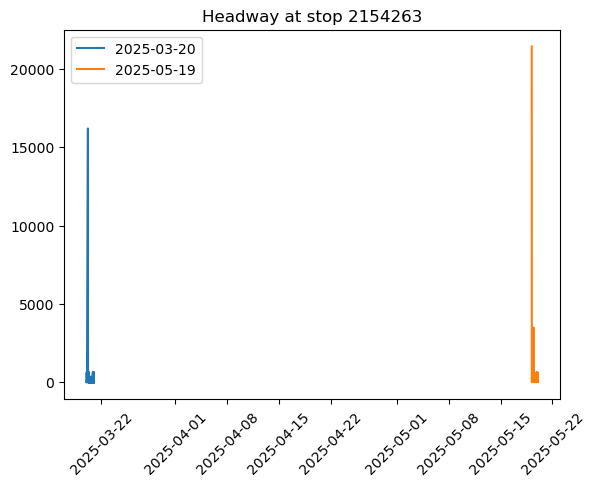

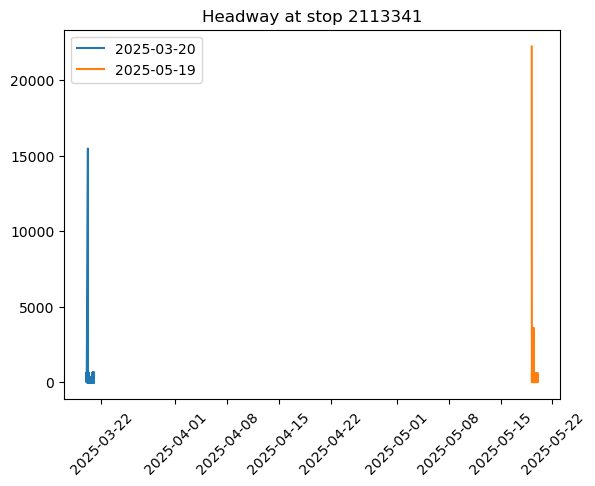

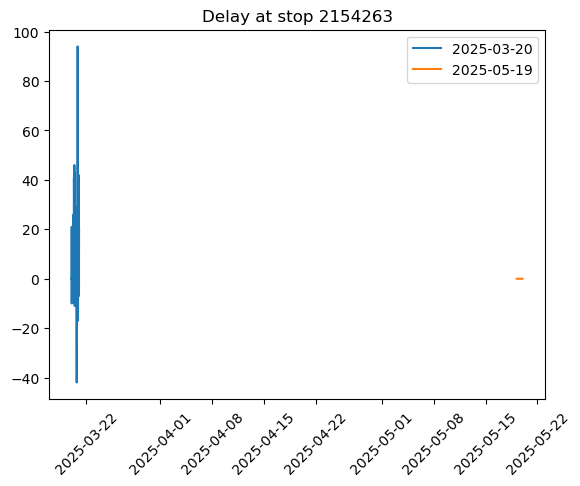

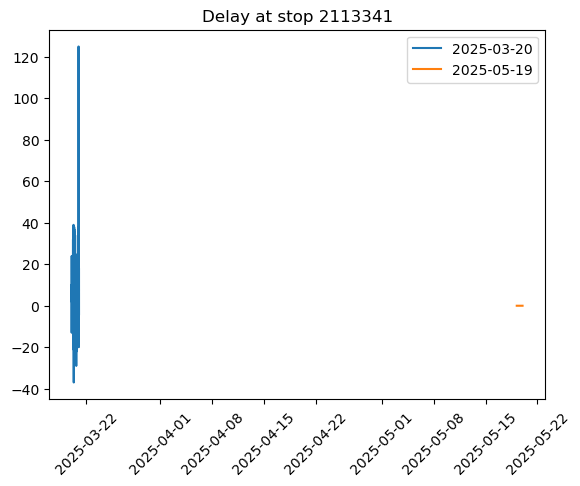

In [10]:
days = np.random.choice(feats_all["snapshot_timestamp"].dt.date.unique(), 2, replace=False)
stations = np.random.choice(feats_all["stop_id"].unique(), 2, replace=False)
for stop in stations:
    plt.figure()
    sub = feats_all[feats_all["stop_id"] == stop]
    for day in days:
        day_sub = sub[sub["snapshot_timestamp"].dt.date == day]
        plt.plot(day_sub["snapshot_timestamp"], day_sub["headway_t"], label=str(day))
    plt.title(f"Headway at stop {stop}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
for stop in stations:
    plt.figure()
    sub = feats_all[feats_all["stop_id"] == stop]
    for day in days:
        day_sub = sub[sub["snapshot_timestamp"].dt.date == day]
        plt.plot(day_sub["snapshot_timestamp"], day_sub["arrival_delay_t"], label=str(day))
    plt.title(f"Delay at stop {stop}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

## Sydney Metro M Line
The `SMNW_M1` route-id corresponds to the Sydney Metro line currently running Tallawong ⇄ Chatswood.

In [12]:
import folium
import pandas as pd

gtfs_root = project_root / "sample_data" / "static"
routes = pd.read_csv(gtfs_root / "routes.txt")
stops = pd.read_csv(gtfs_root / "stops.txt")
trips = pd.read_csv(gtfs_root / "trips.txt")
stop_times = pd.read_csv(gtfs_root / "stop_times.txt")
shapes = pd.read_csv(gtfs_root / "shapes.txt")

m_route = routes[routes["route_id"] == "SMNW_M1"]
display(m_route)
m_trip = trips[trips["route_id"] == "SMNW_M1"].iloc[0]
shape_points = shapes[shapes["shape_id"] == m_trip["shape_id"]].sort_values("shape_pt_sequence")
line = list(zip(shape_points["shape_pt_lat"], shape_points["shape_pt_lon"]))
stop_ids = stop_times[stop_times["trip_id"] == m_trip["trip_id"]]["stop_id"].unique()
stops_subset = stops[stops["stop_id"].isin(stop_ids)]

m = folium.Map(location=[-33.8, 151.1], zoom_start=11)
folium.PolyLine(line, color="blue", weight=5, opacity=0.7).add_to(m)
for _, row in stops_subset.iterrows():
    folium.Marker([row.stop_lat, row.stop_lon], popup=f"{row.stop_name} ({row.stop_id})").add_to(m)
m

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
0,SMNW_M1,SMNW,M1,Metro North West & Bankstown Line,Sydney Metro Network,401,168388,FFFFFF,NaN
